# Market Data Analysis
This notebook visualizes market data from the `data` folder.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Load and Combine Data
Load all CSV files from the `data` folder and combine them into a single DataFrame.

In [26]:
data_folder = '../data/marketDataClose25-04'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = []

for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df['Source'] = file  # Add a column to identify the source file
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

## Plot Market Data
Visualize the data from all files.

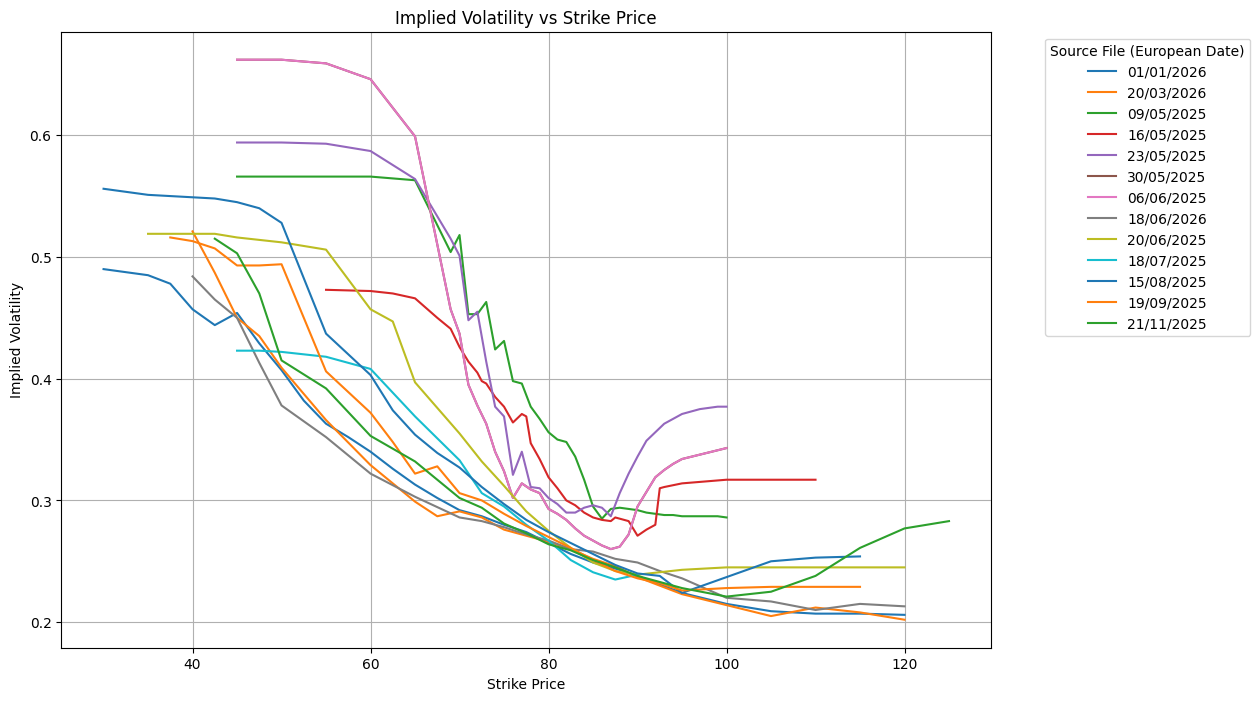

In [27]:
# Convert source filenames to European date format (dd/mm/YYYY)
def convert_to_european_date(filename):
    date_part = filename.split('.')[0]
    month = date_part[:2]
    day = date_part[2:4]
    year = '20' + date_part[4:]
    return f'{day}/{month}/{year}'

# Example plot: Strike vs Implied Volatility
plt.figure(figsize=(12, 8))

for source, group in combined_data.groupby('Source'):
    european_date = convert_to_european_date(source)
    plt.plot(group['Strike'], group['IV_Call'], label=european_date)

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike Price')
plt.legend(title='Source File (European Date)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Plot Mid Prices for Out-of-the-Money Options
Visualize the mid prices for calls above 81.25 and puts below 81.25.

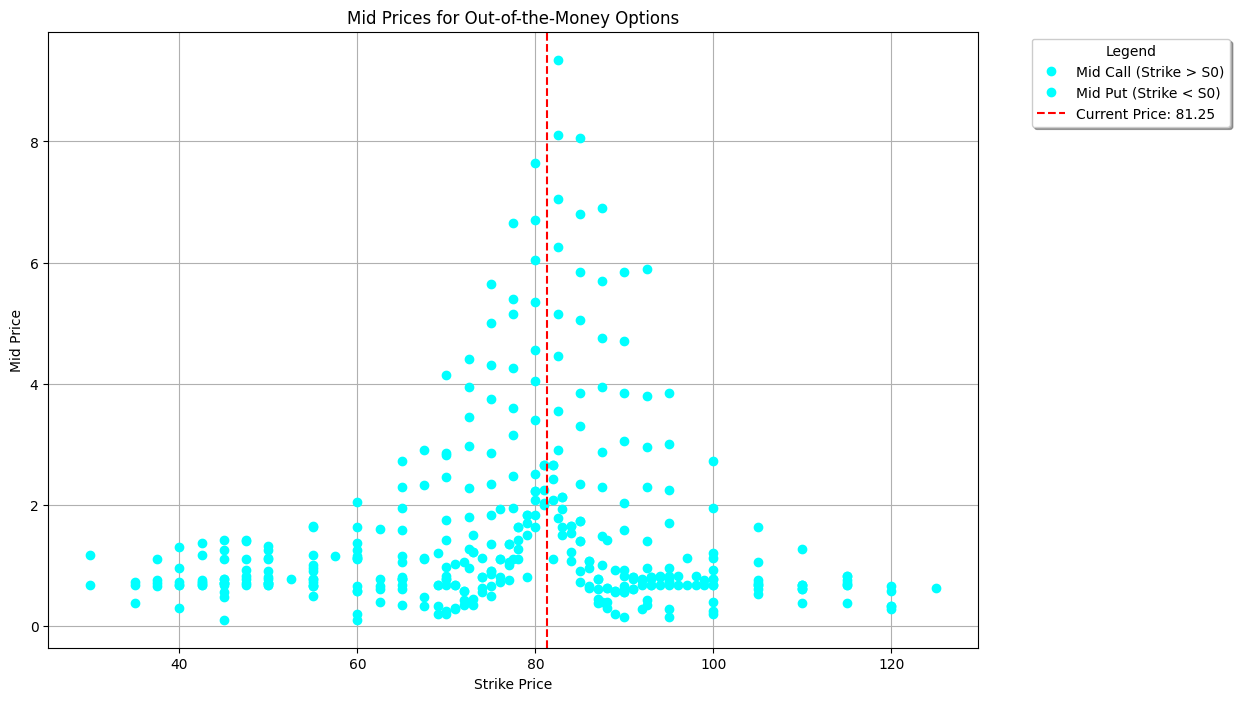

In [28]:
# Filter out-of-the-money options
S0 = 81.25
out_of_money_calls = combined_data.loc[combined_data['Strike'] > S0].copy()
out_of_money_puts = combined_data.loc[combined_data['Strike'] < S0].copy()

# Calculate mid prices for calls and puts
out_of_money_calls['Mid_Call'] = (out_of_money_calls['Bid_Call'] + out_of_money_calls['Ask_Call']) / 2
out_of_money_puts['Mid_Put'] = (out_of_money_puts['Bid_Put'] + out_of_money_puts['Ask_Put']) / 2

# Plot mid prices for calls and puts
plt.figure(figsize=(12, 8))

# Plot mid prices for calls
plt.plot(out_of_money_calls['Strike'], out_of_money_calls['Mid_Call'], 'o', color='cyan', label='Mid Call (Strike > S0)')

# Plot mid prices for puts
plt.plot(out_of_money_puts['Strike'], out_of_money_puts['Mid_Put'], 'o', color='cyan', label='Mid Put (Strike < S0)')

# Display current price on the chart
plt.axvline(x=S0, color='red', linestyle='--', label=f'Current Price: {S0}')

plt.xlabel('Strike Price')
plt.ylabel('Mid Price')
plt.title('Mid Prices for Out-of-the-Money Options')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## 3D Volatility Surface
Visualize the implied volatility surface based on strike and maturity.

In [ ]:
# Prepare data for 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract unique maturities and strikes
maturities = combined_data['Maturity'].unique()
strikes = combined_data['Strike'].unique()

# Create a grid for strikes and maturities
X, Y = np.meshgrid(strikes, maturities)

# Interpolate implied volatilities
Z = np.zeros_like(X, dtype=float)
for i, maturity in enumerate(maturities):
    for j, strike in enumerate(strikes):
        subset = combined_data[(combined_data['Maturity'] == maturity) & (combined_data['Strike'] == strike)]
        if not subset.empty:
            Z[i, j] = subset['IV_Call'].mean()

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='k')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('3D Volatility Surface')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()